In [1]:
import sys
import os
from datetime import datetime
import time
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
pd.set_option('display.max_rows', None)
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor


In [2]:
sys.path.append(os.path.abspath('../src'))
from lib import (
    train_and_evaluate_models,
    create_eui_comparison_plots,
    evaluate_model_strategies,
    calculate_average_metrics,
    create_error_distribution_plots,
    grid_search_best_params
)

# Change n_clusters to 5, 10 or 20

In [3]:
n_clusters = 10  #5, 10 or 20

In [4]:
merged_df_path = "../data/03_processed/merged_df.csv"
merged_df = pd.read_csv(merged_df_path)
merged_df = merged_df.rename(columns={'total_year': 'hdd_total_year'})

# GDP per capita
merged_df['GDP_per_capita'] = merged_df['GDP_2022'] / merged_df['Population_2023']

# Delete Taiwan (temporal)
merged_df = merged_df[merged_df['Country'] != 'Taiwan']

#np.random.seed(123)
#merged_df['is_train'] = np.random.choice([1, 0], size=len(merged_df), p=[0.8, 0.2])

# Train / Test

In [5]:
train_test_split_original_data_path = "../data/03_processed/train_test_split_original_data.csv"
train_test_split_original_data = pd.read_csv(train_test_split_original_data_path)

train_test_split_new_data_path = "../data/03_processed/train_test_split_new_data.csv"
train_test_split_new_data = pd.read_csv(train_test_split_new_data_path)

train_test_split = pd.concat([train_test_split_original_data, train_test_split_new_data], ignore_index=True)

merged_df = merged_df.merge(train_test_split, on=['index', 'geonameid'], how='left')

# We want to keep original data 
merged_df = merged_df[merged_df["source"] == "World Bank CURB"]

# Delete Image Null

In [6]:
print(merged_df.shape)

merged_df = merged_df.dropna(subset=['pca_result'])

print(merged_df.shape)

(481, 78)
(473, 78)


In [7]:
feature_selection = f"{n_clusters}_clusters" 

features = [
    "hdd_total_year", 
    "cdd_total_year", 
    "GDP_per_capita", 
    "Urbanization_Rate_2022",
    "latitude",
    "longitude",  
    "Paris_Agreement",
    "Subnational HDI", 
    "Educational index", 
    "Income index",
    "2m_temperature_2023_avg",
    "2m_dewpoint_temperature_2023_avg",
    "total_precipitation_2023",
    #"longitude_sin", 
    #"longitude_cos", 
    #"latitude_sin", 
    #"latitude_cos",  
    "population_density",

    #Image data
    'pca_result'
    ]

features += [f'Cluster_{n_clusters}_{i}' for i in range(n_clusters)]


feature_abbreviations = {
    "hdd_total_year": "Heating Degree Days",
    "cdd_total_year": "Cooling Degree Days", 
    "GDP_per_capita": "GDP per Capita",
    "Urbanization_Rate_2022": "Urbanization Rate",
    "latitude": "Latitude",
    "longitude": "Longitude",  
    "Paris_Agreement": "Paris Agreement",
    "Subnational HDI": "Human Development Index",
    "Educational index": "Educational Index", 
    "Income index": "Income Index",
    "2m_temperature_2023_avg": "Avg Temperature",
    "2m_dewpoint_temperature_2023_avg": "Avg Dewpoint Temp",
    "total_precipitation_2023": "Precipitation",
    "longitude_sin": "Longitude Sin", 
    "longitude_cos": "Longitude Cos", 
    "latitude_sin": "Latitude Sin", 
    "latitude_cos": "Latitude Cos",  
    "population_density": "Population Density",

    # Image-based features
    "pca_result": "First Principal Component (PCA)",
}

feature_abbreviations.update({f'Cluster_{n_clusters}_{i}': f'Fuzzy C-means Image Cluster {i}' for i in range(n_clusters)})


target_columns = [
    "Residential EUI (kWh/m2/year)",
    "Non-residential EUI (kWh/m2/year)"
]

regions = ['Asia & Oceania', 'Europe', 'Africa', 'Central and South America', 'Northern America']


# Random Forest

In [8]:
# using best combination from https://github.com/AliciaXia222/Capstone-Team-Climate-Trace/blob/main/notebooks/062_Experiments_RF_GridSearch.ipynb

In [9]:
# Random Forest parameters

rf_params = {
    'n_estimators': 30,
    'max_depth': 5,
    'min_samples_split': 2,
    'min_samples_leaf': 3,
    'max_features': 'sqrt',   
    'bootstrap': False,      
    'random_state': 42,
    'n_jobs': -1 ,
    'criterion': 'absolute_error'        
}

### Random Forest - Within Domain

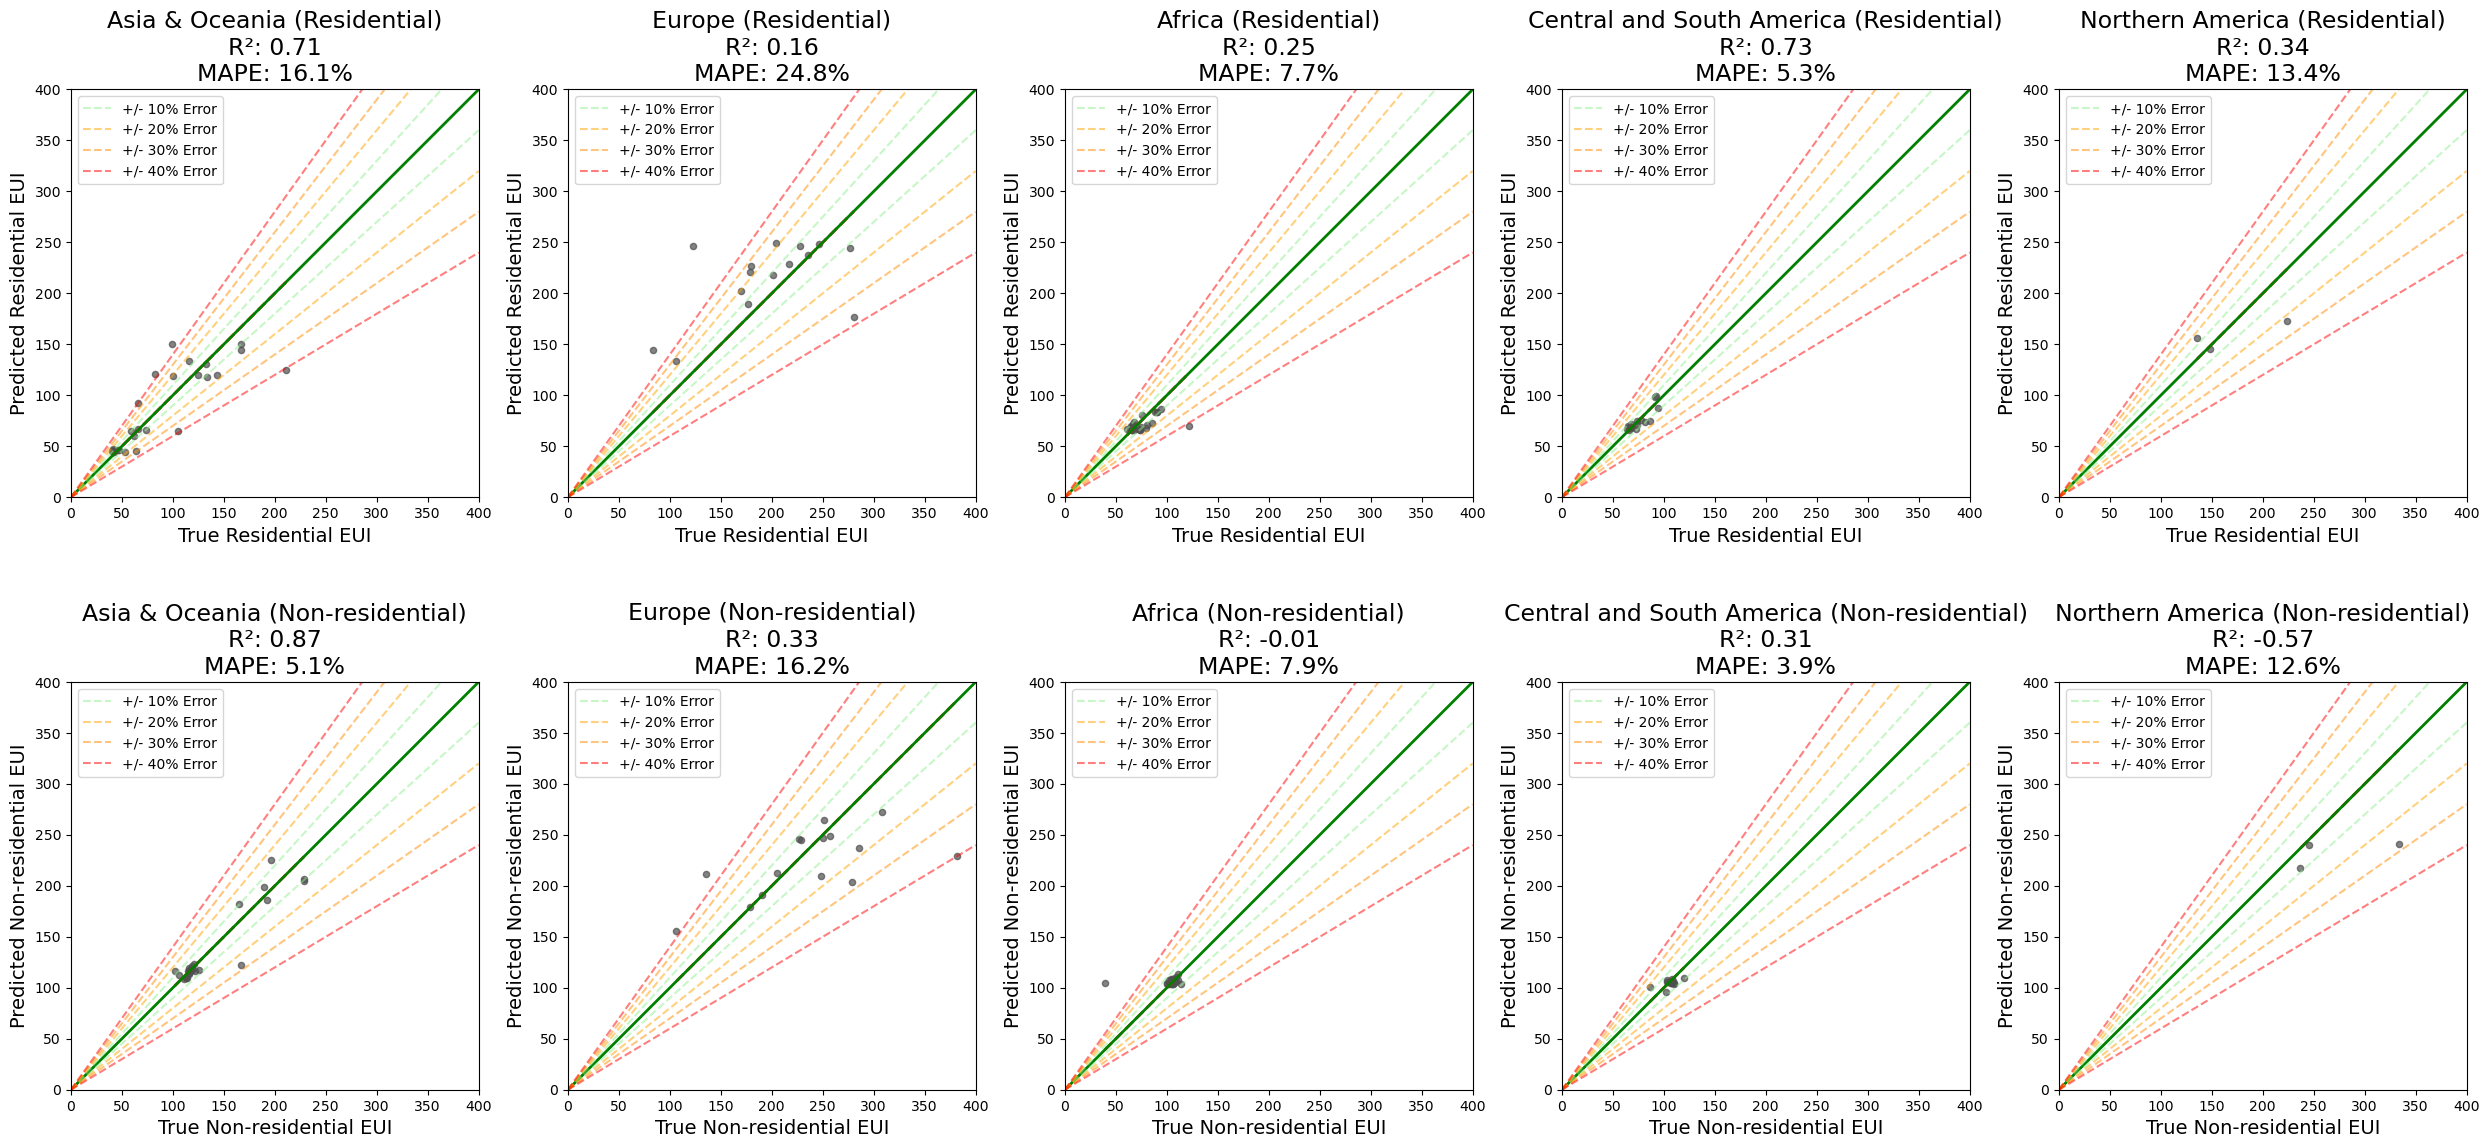

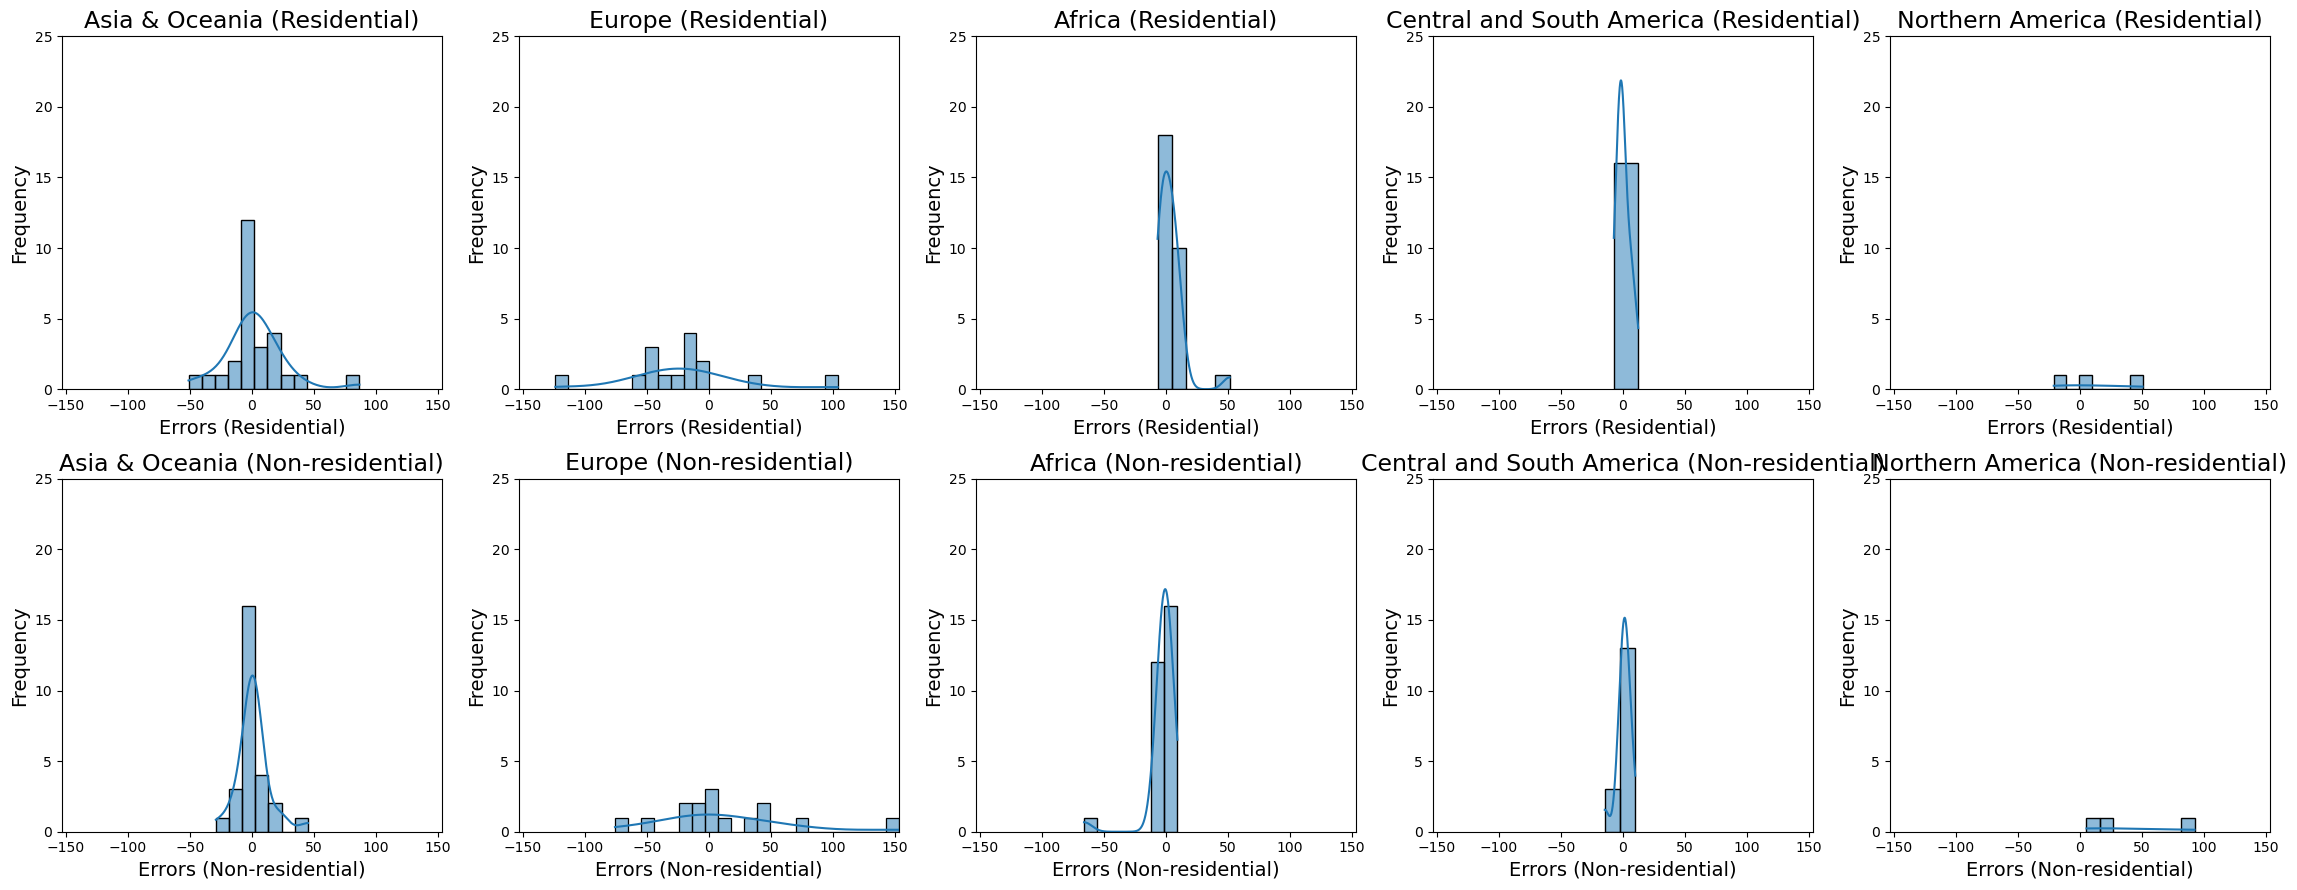

In [10]:
# Within-domain
model_rf_within = RandomForestRegressor(**rf_params)
results_rf_within = train_and_evaluate_models(
    merged_df=merged_df,
    regions=regions,
    features=features,
    model=model_rf_within,
    strategy='within_domain'
)

create_eui_comparison_plots(
    results_rf_within, 
    save_path=f'../figures/model_plots/{feature_selection}/rf_within_domain_eui_predictions.png'
)

create_error_distribution_plots(
    results_rf_within,
    save_path=f'../figures/model_plots/{feature_selection}/rf_within_domain_error_distribution.png'
)


### Random Forest - Cross Domain

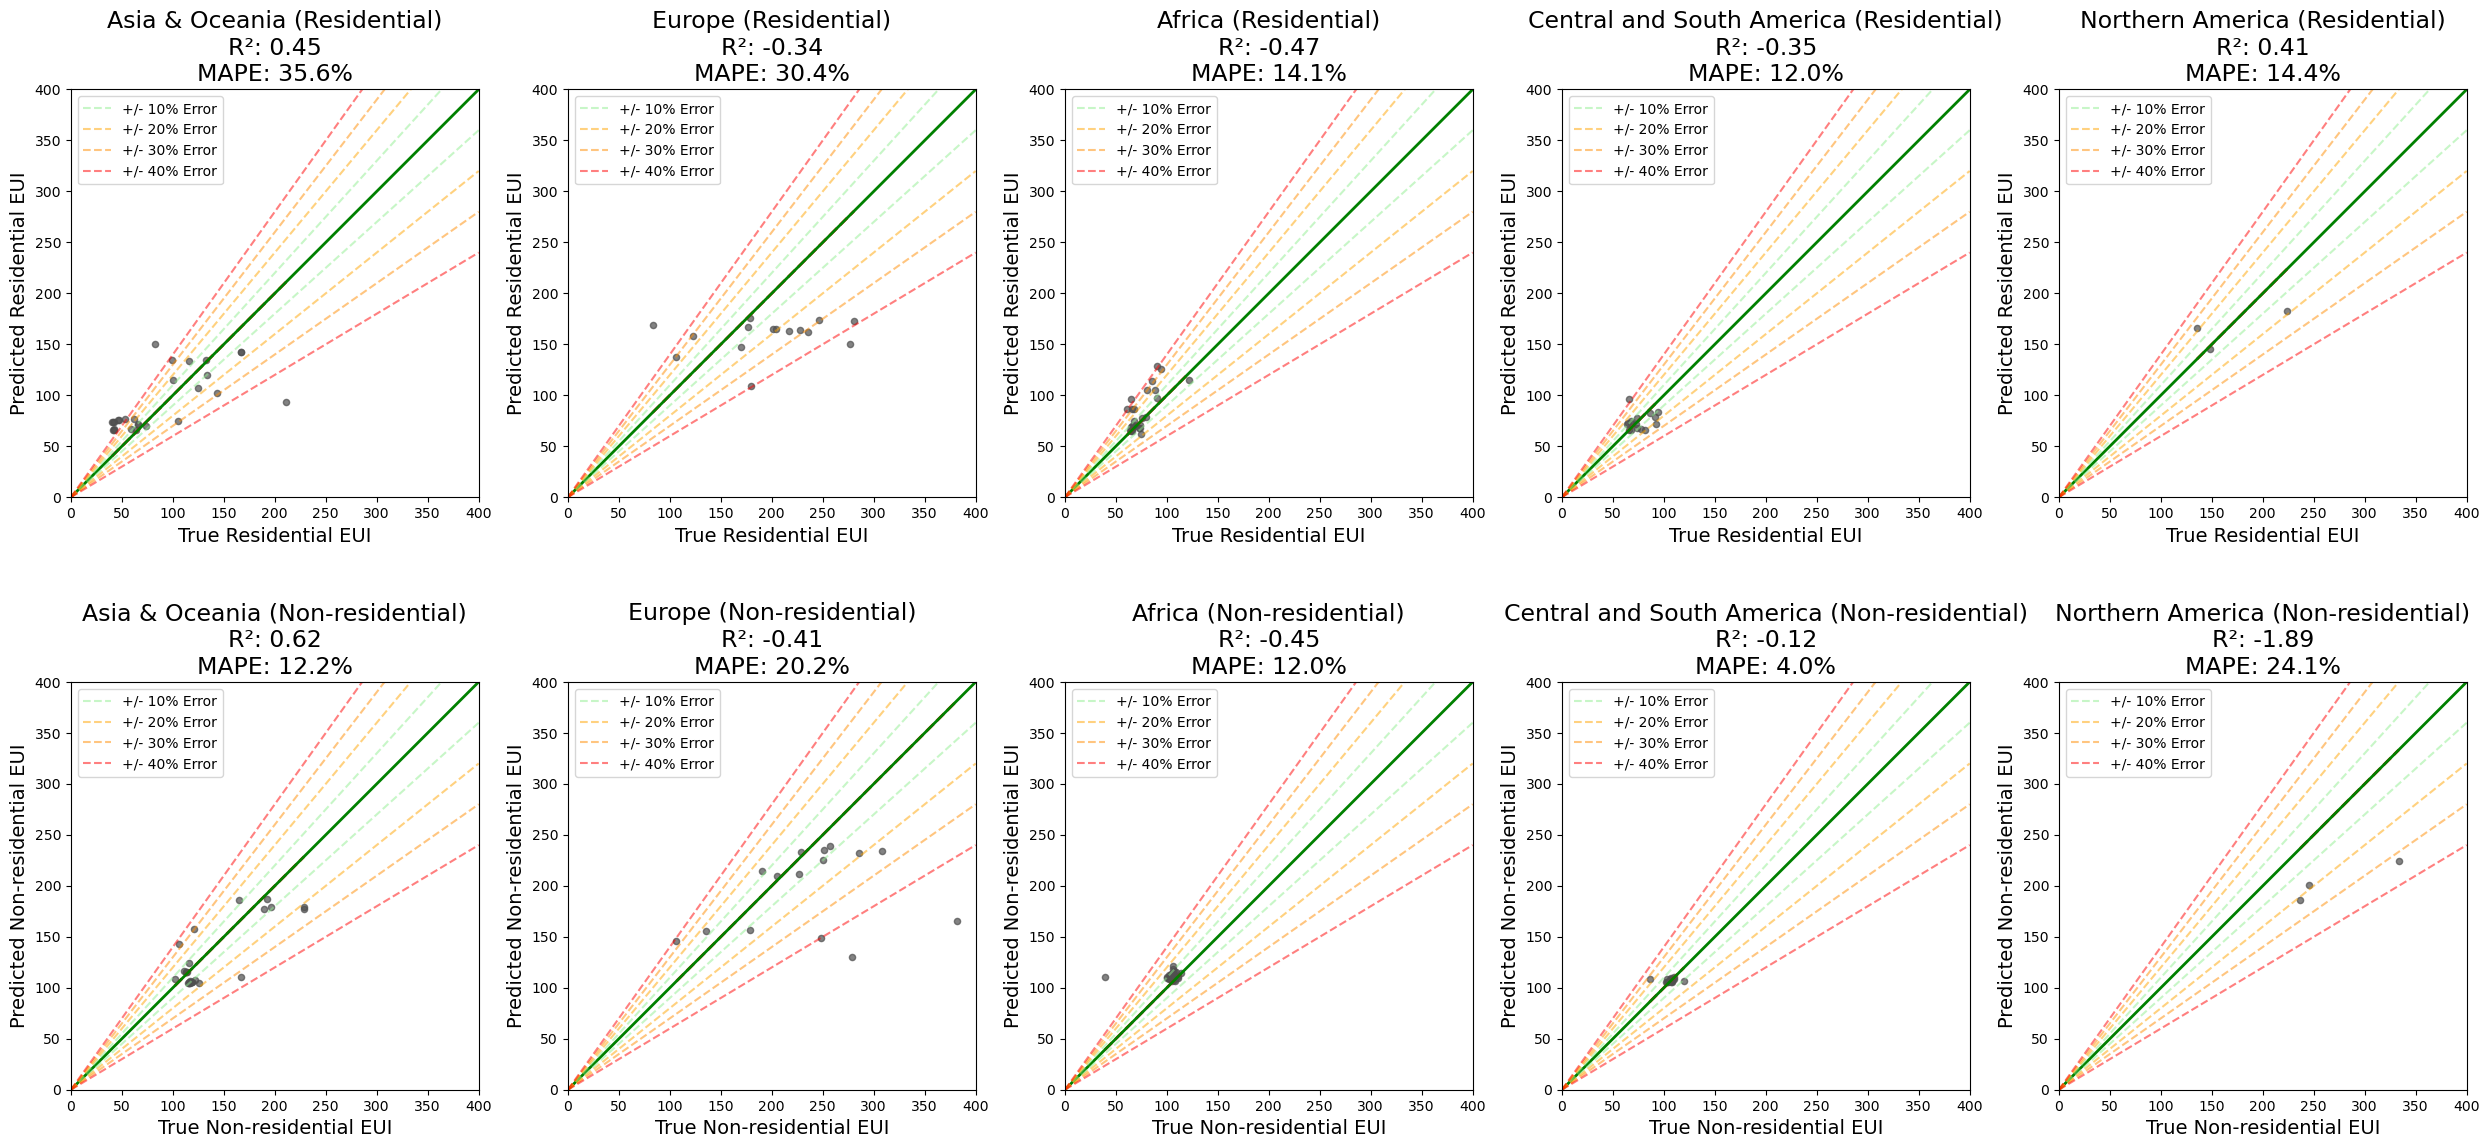

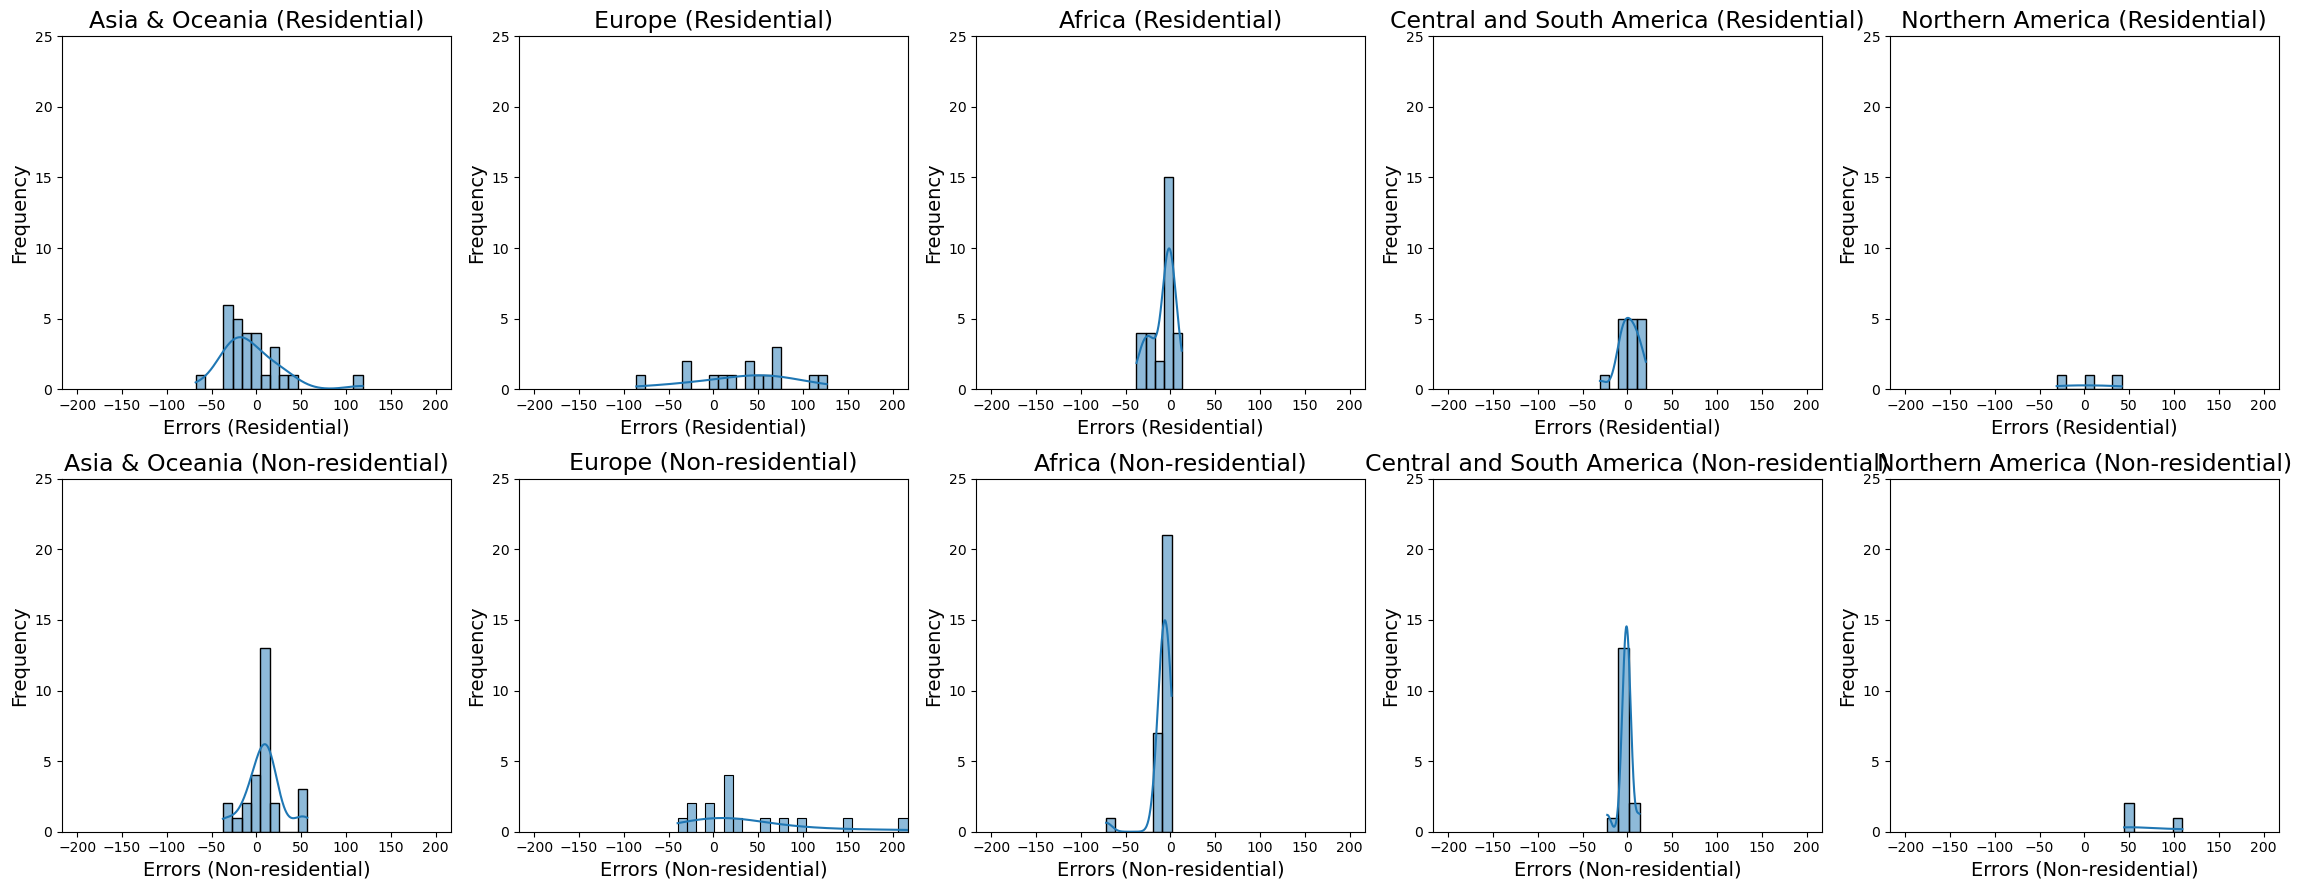

In [11]:
# Cross-domain
model_rf_cross = RandomForestRegressor(**rf_params)
results_rf_cross = train_and_evaluate_models(
    merged_df=merged_df,
    regions=regions,
    features=features,
    model=model_rf_cross,
    strategy='cross_domain'
)

create_eui_comparison_plots(
    results_rf_cross,
    save_path=f'../figures/model_plots/{feature_selection}/rf_cross_domain_eui_predictions.png'
)

create_error_distribution_plots(
    results_rf_cross,
    save_path=f'../figures/model_plots/{feature_selection}/rf_cross_domain_error_distribution.png'
)


### Random Forest - All Domain

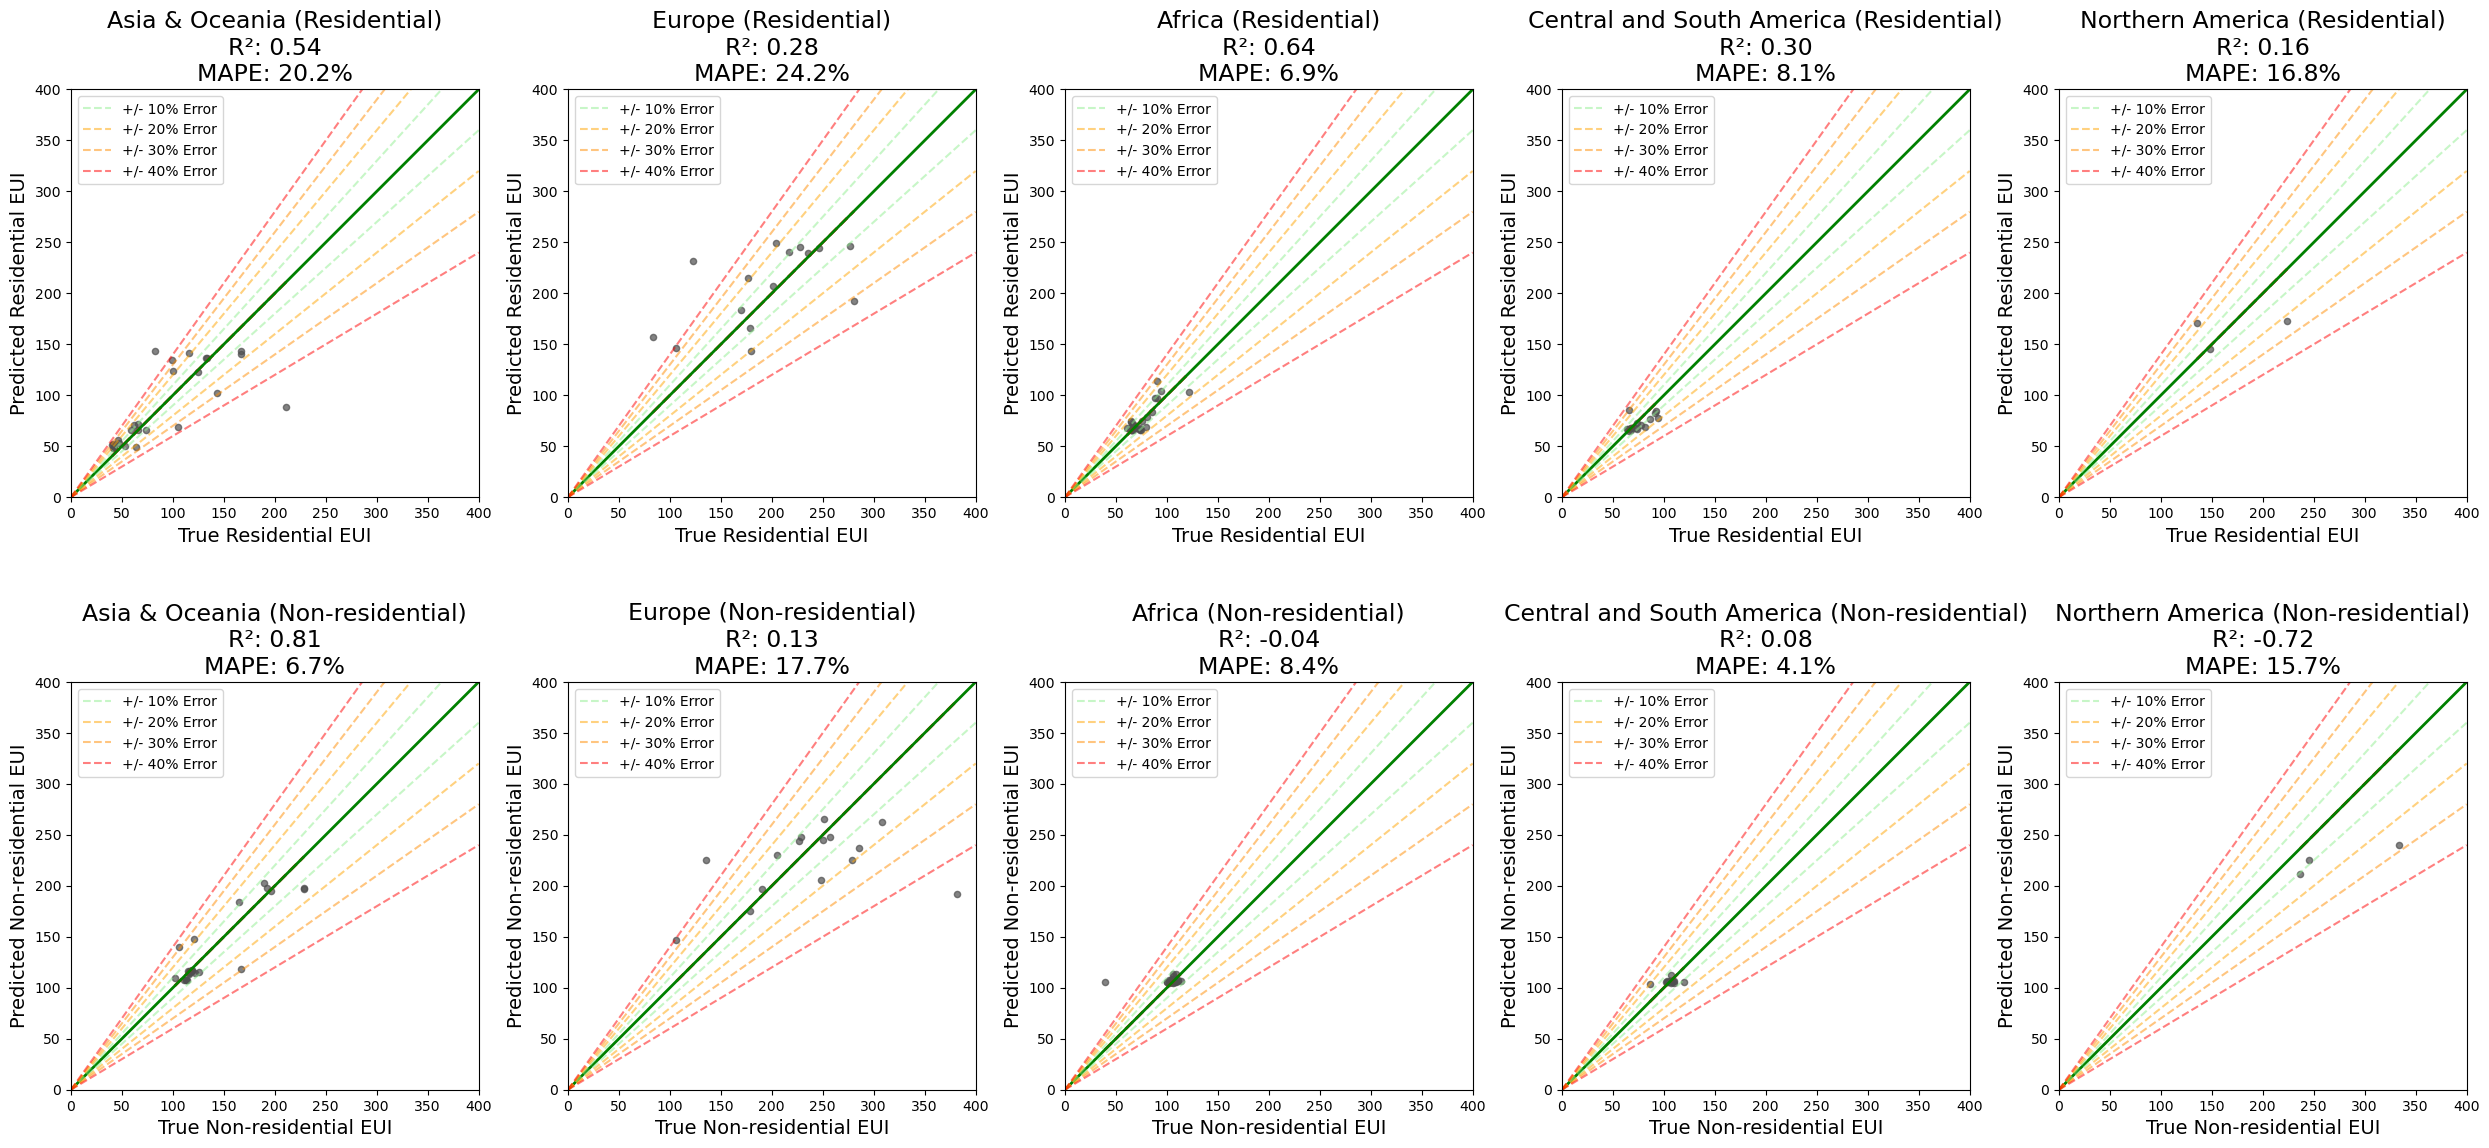

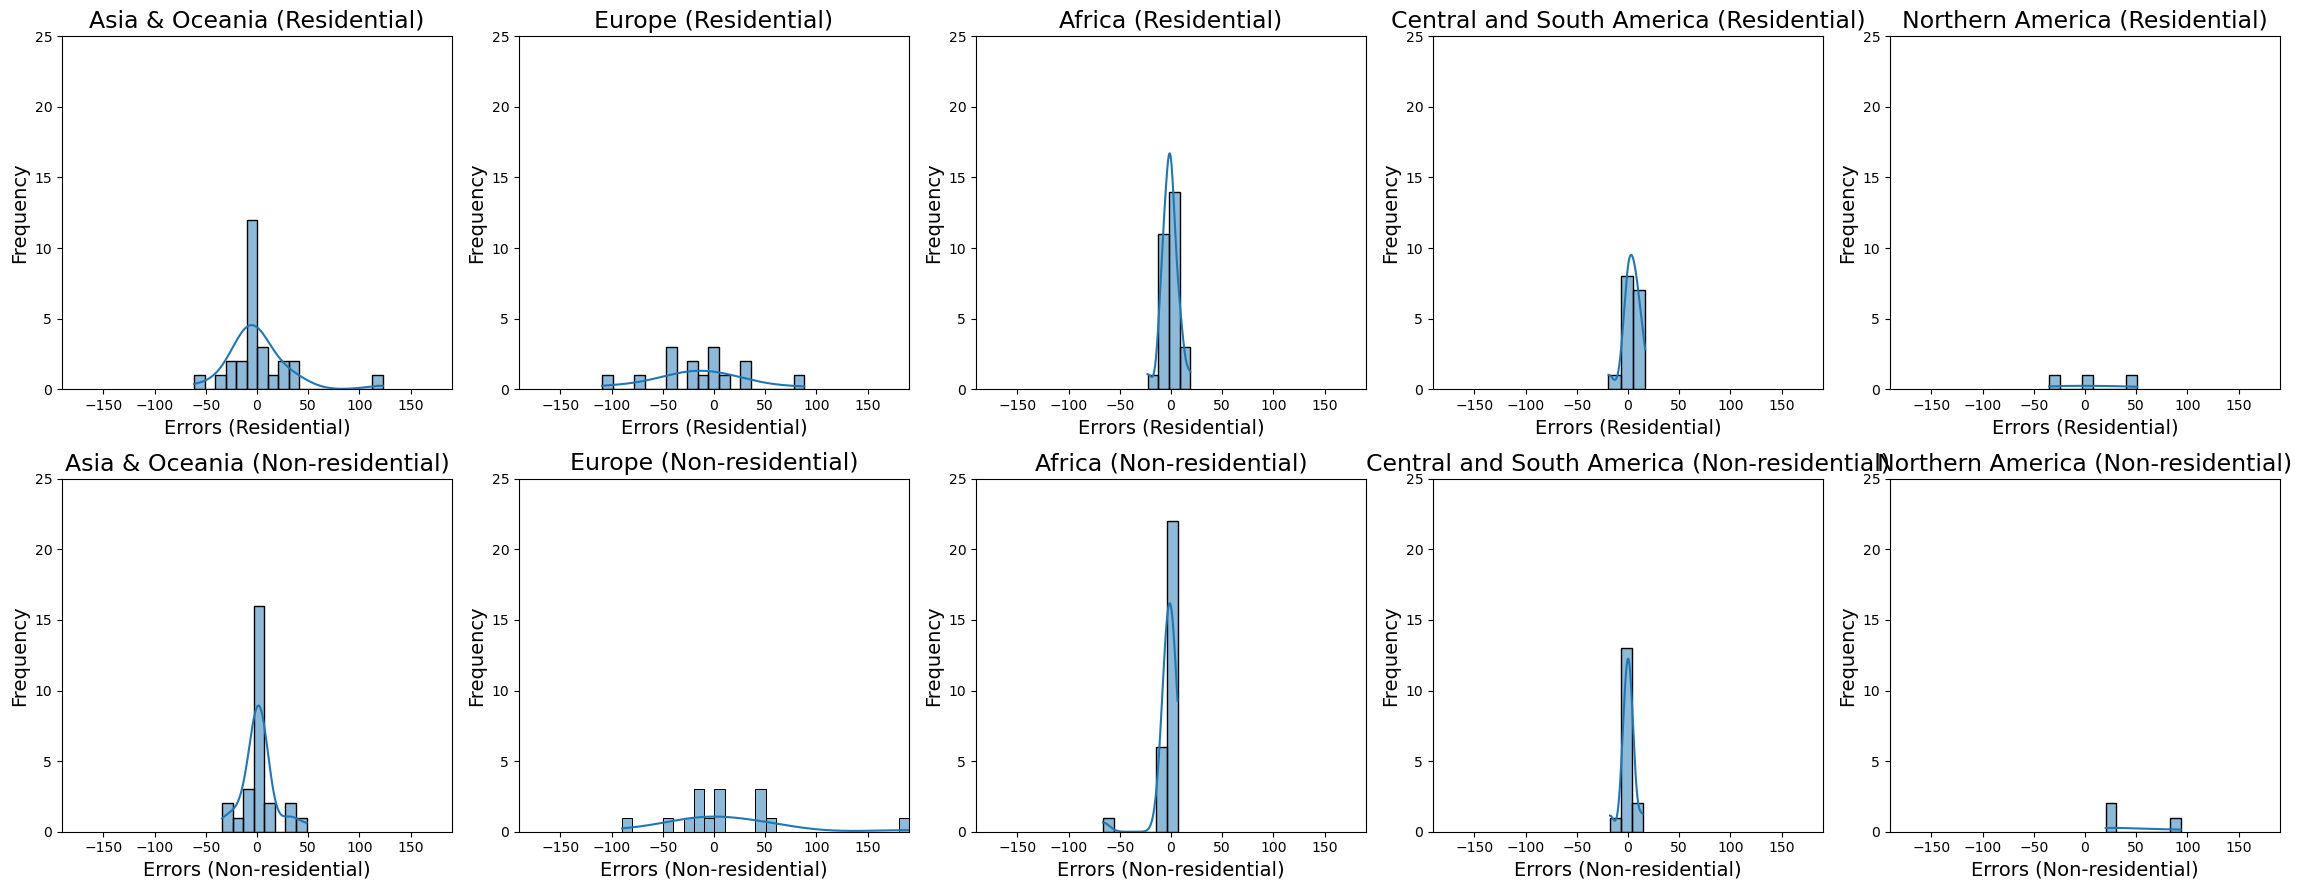

In [12]:
# All-domain
model_rf_all = RandomForestRegressor(**rf_params)
results_rf_all = train_and_evaluate_models(
    merged_df=merged_df,
    regions=regions,
    features=features,
    model=model_rf_all,
    strategy='all_domain'
)

create_eui_comparison_plots(
    results_rf_all,
    save_path=f'../figures/model_plots/{feature_selection}/rf_all_domain_eui_predictions.png'
)

create_error_distribution_plots(
    results_rf_all,
    save_path=f'../figures/model_plots/{feature_selection}/rf_all_domain_error_distribution.png'
)


In [13]:
RFModel = lambda: RandomForestRegressor(**rf_params)
rf_detailed_results = evaluate_model_strategies(
    merged_df=merged_df,
    regions=regions,
    features=features,
    model_type=RFModel,  
    feature_abbreviations=feature_abbreviations,
    model_details=", ".join(f"{k}={v}" for k, v in rf_params.items())
)
rf_detailed_results['Model'] = 'RandomForestRegressor'

rf_average_results = calculate_average_metrics(rf_detailed_results).reset_index()
rf_average_results

,Target,Strategy,Model,Model Details,Features Used,Features Abbreviated,MAPE,R²,MSE,RMSE,MAE,WAPE
0,Non-residential EUI (kWh/m2/year),within_domain,RandomForestRegressor,"n_estimators=30, max_depth=5, min_samples_spli...","hdd_total_year, cdd_total_year, GDP_per_capita...",Heating Degree Days | Cooling Degree Days | GD...,9.14,0.190,1245.916,27.928,18.350,8.74
1,Non-residential EUI (kWh/m2/year),cross_domain,RandomForestRegressor,"n_estimators=30, max_depth=5, min_samples_spli...","hdd_total_year, cdd_total_year, GDP_per_capita...",Heating Degree Days | Cooling Degree Days | GD...,14.50,-0.449,2485.024,39.464,29.964,14.32
2,Non-residential EUI (kWh/m2/year),all_domain,RandomForestRegressor,"n_estimators=30, max_depth=5, min_samples_spli...","hdd_total_year, cdd_total_year, GDP_per_capita...",Heating Degree Days | Cooling Degree Days | GD...,10.52,0.054,1500.918,30.773,21.213,10.06
3,Residential EUI (kWh/m2/year),within_domain,RandomForestRegressor,"n_estimators=30, max_depth=5, min_samples_spli...","hdd_total_year, cdd_total_year, GDP_per_capita...",Heating Degree Days | Cooling Degree Days | GD...,13.46,0.437,884.621,24.906,18.029,13.44
4,Residential EUI (kWh/m2/year),cross_domain,RandomForestRegressor,"n_estimators=30, max_depth=5, min_samples_spli...","hdd_total_year, cdd_total_year, GDP_per_capita...",Heating Degree Days | Cooling Degree Days | GD...,21.30,-0.061,1339.433,31.396,25.251,19.90
5,Residential EUI (kWh/m2/year),all_domain,RandomForestRegressor,"n_estimators=30, max_depth=5, min_samples_spli...","hdd_total_year, cdd_total_year, GDP_per_capita...",Heating Degree Days | Cooling Degree Days | GD...,15.24,0.382,933.216,26.229,19.360,14.78


In [14]:
(14.50+21.30	)/2

17.9

In [15]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
rf_detailed_results.to_csv(f'../results/{feature_selection}/{timestamp}_rf_detailed_results.csv')
rf_average_results.to_csv(f'../results/{feature_selection}/{timestamp}_rf_average_results.csv')

# 